Notebook to test generalizability in predicting link time series. The idea is to see if we can use the group-level beta coefficients to see how they perform in predicting the edge time series of new subjects.

In [1]:
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from nilearn.image import load_img
from scipy.spatial.distance import squareform
from nilearn import plotting
from matplotlib.colors import ListedColormap
plt.rcParams["font.family"] = "arial"

/home/javi/.local/lib/python3.8/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
final_subjects = np.loadtxt("../data/subjects_intersect_motion_035.txt")
n_subjects = len(final_subjects)
print(n_subjects)

n_scans = 280 #

rsn_networks = pd.read_csv("../data/atlases/shen_268_parcellation_networklabels.csv").Network
rsn_networks

coords = plotting.find_parcellation_cut_coords("../data/atlases/shen_2mm_268_parcellation.nii.gz")

rsn_lables = ['medial-frontal', 'frontoparietal', 'default-mode','subcortical-cerebellum',
              'motor', 'visual-1', 'visual-2', 'visual-association']
print(rsn_lables)
# Add colours to each network (R, G, B)
rsn_colors = [[128,0,128], [0,255,255], [255,215,0], [255,69,0],
              [0,0,128], [255,0,255], [0,255,0], [128,0,0]
             ]
print(rsn_colors)

rsn_norm_colors = [(rgb[0]/255, rgb[1]/255, rgb[2]/255) for rgb in rsn_colors]
rsn_cmap = ListedColormap(rsn_norm_colors)
print(rsn_cmap)

node_colors = [tuple([rsn_colors[ii-1][0]/255, rsn_colors[ii-1][1]/255, rsn_colors[ii-1][2]/255]) \
               for ii in rsn_networks.to_list()]

242
['medial-frontal', 'frontoparietal', 'default-mode', 'subcortical-cerebellum', 'motor', 'visual-1', 'visual-2', 'visual-association']
[[128, 0, 128], [0, 255, 255], [255, 215, 0], [255, 69, 0], [0, 0, 128], [255, 0, 255], [0, 255, 0], [128, 0, 0]]


In [3]:
# WITHIN task performances
r2_scores_stroop_stroop = np.load("../results/predictions/gsr/scores_stroop_stroop.npz")['r2_scores']
r2_scores_stroop_stroop = r2_scores_stroop_stroop.reshape((r2_scores_stroop_stroop.shape[0]*r2_scores_stroop_stroop.shape[1], 
                                                           r2_scores_stroop_stroop.shape[-1]))

r2_scores_msit_msit = np.load("../results/predictions/gsr/scores_msit_msit.npz")['r2_scores']
r2_scores_msit_msit = r2_scores_msit_msit.reshape((r2_scores_msit_msit.shape[0]*r2_scores_msit_msit.shape[1], 
                                                   r2_scores_msit_msit.shape[-1]))

# BETWEEN task performances
r2_scores_stroop_msit = np.load("../results/predictions/gsr/scores_stroop_msit.npz")['r2_scores']
r2_scores_stroop_msit = r2_scores_stroop_msit.reshape((r2_scores_stroop_msit.shape[0]*r2_scores_stroop_msit.shape[1], 
                                                       r2_scores_stroop_msit.shape[-1]))

r2_scores_msit_stroop = np.load("../results/predictions/gsr/scores_msit_stroop.npz")['r2_scores']
r2_scores_msit_stroop = r2_scores_msit_stroop.reshape((r2_scores_msit_stroop.shape[0]*r2_scores_msit_stroop.shape[1], 
                                                       r2_scores_stroop_stroop.shape[-1]))

In [4]:
def summary_stat(scores):
    from scipy.stats import sem
    mean_r2_edges = scores.mean(0)
    sem_r2_edges = sem(scores, axis=0)
    u_r2_emp = mean_r2_edges + 1.96*sem_r2_edges
    l_r2_emp = mean_r2_edges - 1.96*sem_r2_edges
    
    return mean_r2_edges, l_r2_emp, u_r2_emp

In [5]:
mean_r2_stroop_stroop, l_r2_stroop_stroop, u_r2_stroop_stroop = summary_stat(r2_scores_stroop_stroop)
mean_r2_msit_msit, l_r2_msit_msit, u_r2_msit_msit = summary_stat(r2_scores_msit_msit)

mean_r2_stroop_msit, l_r2_stroop_msit, u_r2_stroop_msit = summary_stat(r2_scores_stroop_msit)
mean_r2_msit_stroop, l_r2_msit_stroop, u_r2_msit_stroop = summary_stat(r2_scores_msit_stroop)

within_task_scores_df = pd.DataFrame({'stroop_stroop': mean_r2_stroop_stroop, 
                                      'msit_msit': mean_r2_msit_msit
                                     })


between_task_scores_df = pd.DataFrame({'stroop_msit': mean_r2_stroop_msit, 
                                      'msit_stroop': mean_r2_msit_stroop
                                     })

In [6]:
mask_1 = (l_r2_stroop_stroop>0) & (u_r2_stroop_stroop>0)
mask_2 = (l_r2_stroop_msit>0) & (u_r2_stroop_msit>0)
mask_3 = (l_r2_msit_msit>0) & (u_r2_msit_msit>0)
mask_4 = (l_r2_msit_stroop>0) & (u_r2_msit_stroop>0)

print(f"# reliable links Stroop-Stroop: {sum(mask_1)}, "
      f" mean R2 across these edges: {np.median(mean_r2_stroop_stroop[mask_1]):.3f}"
     )
print(f"# reliable links Stroop-MSIT: {sum(mask_2)},"
      f" mean R2 across these edges: {np.median(mean_r2_stroop_msit[mask_2]):.3f}"
     )
print(f"# reliable links MSIT-MSIT: {sum(mask_3)},"
      f" mean R2 across these edges: {np.median(mean_r2_msit_msit[mask_3]):.3f}"
     )
print(f"# reliable links MSIT-Stroop: {sum(mask_4)},"
      f" mean R2 across these edges: {np.median(mean_r2_msit_stroop[mask_4]):.3f}"
     )

# reliable links Stroop-Stroop: 2573,  mean R2 across these edges: 0.026
# reliable links Stroop-MSIT: 998, mean R2 across these edges: 0.022
# reliable links MSIT-MSIT: 2567, mean R2 across these edges: 0.028
# reliable links MSIT-Stroop: 814, mean R2 across these edges: 0.020


In [7]:
from scipy.spatial.distance import dice

print(f"# of common edges within and betweeen in Stroop: {sum(mask_1 & mask_2)}, "
      f"intersect of both masks: {1-dice(mask_1, mask_2):.3f}")
print(f"# of common edges within and betweeen in MSIT: {sum(mask_3 & mask_4)}, "
      f"intersect of both masks: {1-dice(mask_3, mask_4):.3f}")
#print(1-dice(mask_1, mask_3))

# of common edges within and betweeen in Stroop: 474, intersect of both masks: 0.265
# of common edges within and betweeen in MSIT: 386, intersect of both masks: 0.228


In [8]:
# Load significant results from statistical analysis at group-level
from statsmodels.stats.multitest import multipletests
p_vals_stroop = squareform(np.squeeze(load_img("../results/second-level/edge_gsr/shen/task-stroop/Incongruent-Congruent/z_score.nii.gz").get_fdata()), 
           checks=False)
p_vals_stroop = multipletests(stats.norm.sf(abs(p_vals_stroop))*2, method="bonferroni")[0]

print("Proportion of predictive links in Stroop that were also"
      f" significant: {sum(mask_1[p_vals_stroop])/sum(p_vals_stroop)*100:.2f}"
     )

p_vals_msit = squareform(np.squeeze(load_img("../results/second-level/edge_gsr/shen/task-msit/Incongruent-Congruent/z_score.nii.gz").get_fdata()), 
           checks=False)
p_vals_msit = multipletests(stats.norm.sf(abs(p_vals_msit))*2, method="bonferroni")[0]
print("Proportion of predictive links in MSIT that were also"
      f" significant: {sum(mask_3[p_vals_msit])/sum(p_vals_msit)*100:.2f}"
     )

Proportion of predictive links in Stroop that were also significant: 88.44
Proportion of predictive links in MSIT that were also significant: 93.59


In [9]:
xvmax = np.max([mean_r2_stroop_stroop, mean_r2_msit_msit]) + 0.01
xvmin = np.min([mean_r2_stroop_stroop, mean_r2_msit_msit]) - 0.01
        
yvmax = np.max([mean_r2_stroop_msit, mean_r2_msit_stroop]) + 0.01
yvmin = np.min([mean_r2_stroop_msit, mean_r2_msit_stroop]) - 0.03

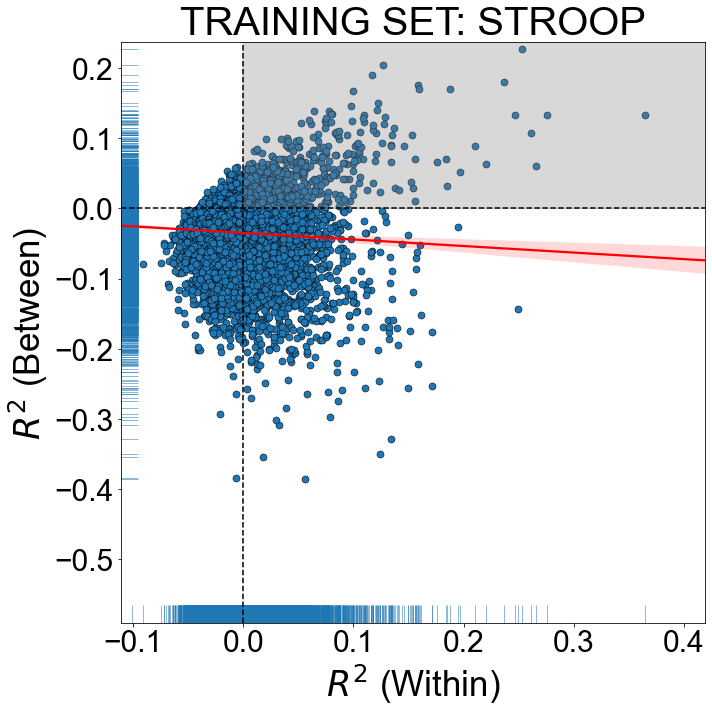

In [11]:
within_task = mean_r2_stroop_stroop
between_task = mean_r2_stroop_msit

fig, ax= plt.subplots(figsize=(10,10))
sns.scatterplot(x=within_task, y=between_task, ax=ax,
           edgecolor="black", linewidth=0.5, s=50)
sns.rugplot(x=within_task, y=between_task, ax=ax, height=0.03,
            expand_margins=False, alpha=0.5)

ax.set_xlabel("$R^2$ (Within)", size=35)
ax.set_ylabel("$R^2$ (Between)", size=35)
ax.tick_params(labelsize=30)
ax.set_xticks([-0.1, 0, 0.1, 0.2, 0.3, 0.4])
ax.set_yticks([-0.5,-0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3])
ax.set_xlim([xvmin, xvmax])
ax.set_ylim([yvmin, yvmax])

sns.regplot(x=within_task, y=between_task,
            ax=ax, line_kws = {'color':'red'},
            scatter=False, truncate=False)

ax.axvspan(0, xvmax, ymin=0.715, ymax=1.0, alpha=0.3, color='grey')

xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
ax.hlines(y=0, xmin=xmin, xmax=xmax, linestyle="--", color='k')
ax.vlines(x=0, ymin=ymin, ymax=ymax, linestyle="--", color='k')
ax.set_title("TRAINING SET: STROOP", size=40)
plt.tight_layout()
plt.savefig("../plots/predictions_training_stroop.svg", dpi=300)
plt.savefig("../plots/predictions_training_stroop.png", dpi=300)
plt.savefig("../plots/predictions_training_stroop.pdf", dpi=300)

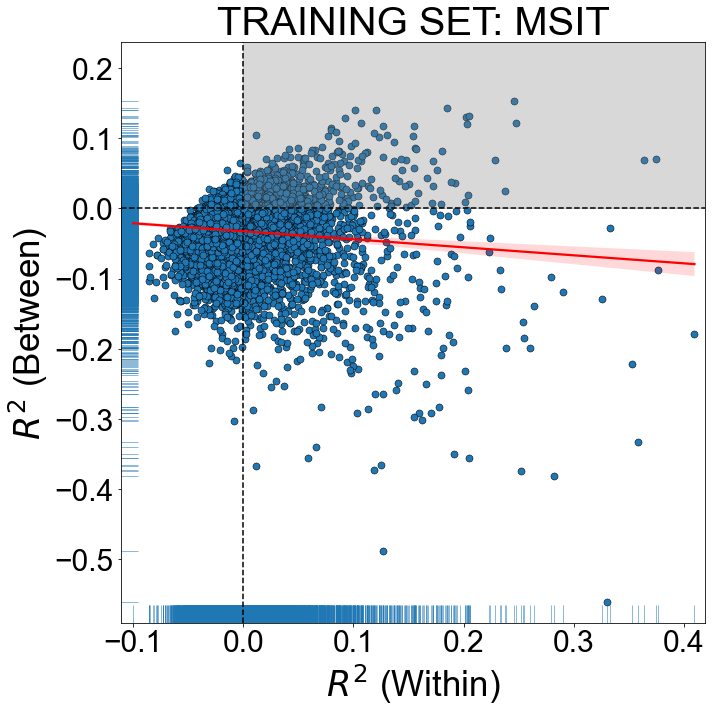

In [12]:
within_task = mean_r2_msit_msit
between_task = mean_r2_msit_stroop

fig, ax= plt.subplots(figsize=(10,10))
sns.scatterplot(x=within_task, y=between_task, ax=ax,
           edgecolor="black", linewidth=0.5, s=50)
sns.rugplot(x=within_task, y=between_task, ax=ax, height=0.03,
            expand_margins=False, alpha=0.5)

sns.regplot(x=within_task, y=between_task,
            ax=ax, line_kws = {'color':'red'},
            scatter=False)

ax.set_xlabel("$R^2$ (Within)", size=35)
ax.set_ylabel("$R^2$ (Between)", size=35)
#ax.set_title( "WITHIN-TASKS\n EDGE-WISE $R^2$", size=40)
ax.tick_params(labelsize=30)
ax.set_xticks([-0.1, 0, 0.1, 0.2, 0.3, 0.4])
ax.set_yticks([-0.5,-0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3])

ax.axvspan(0, xvmax, ymin=0.715, ymax=1.0, alpha=0.3, color='grey')
ax.set_xlim([xvmin, xvmax])
ax.set_ylim([yvmin, yvmax])
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
ax.hlines(y=0, xmin=xmin, xmax=xmax, linestyle="--", color='k')
ax.vlines(x=0, ymin=ymin, ymax=ymax, linestyle="--", color='k')
ax.set_title("TRAINING SET: MSIT", size=40)
plt.tight_layout()
plt.savefig("../plots/predictions_training_msit.svg", dpi=300)
plt.savefig("../plots/predictions_training_msit.png", dpi=300)
plt.savefig("../plots/predictions_training_msit.pdf", dpi=300)

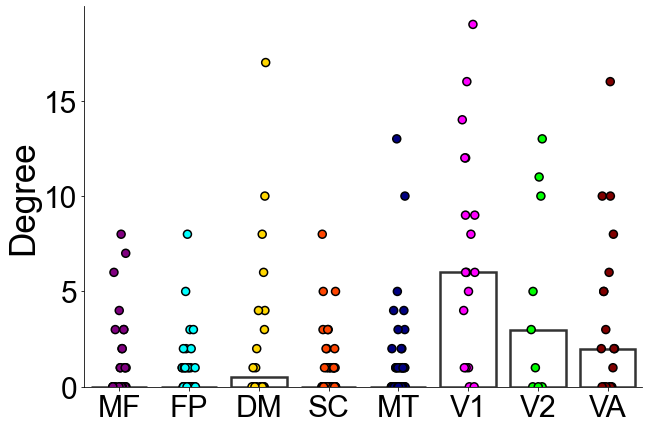

In [16]:
mask_all_edges = (mask_1) & (mask_2) & (mask_3) & (mask_4)
degree_df = pd.DataFrame({'rsn': rsn_networks, 'degree':np.sum(squareform(mask_all_edges), axis=1)})
fig, ax = plt.subplots(figsize=(10,7))
g = sns.stripplot(x='rsn', y='degree', hue='rsn', data=degree_df, ax=ax, 
              size=8, edgecolor="black", linewidth=1.5, c="red", palette=rsn_norm_colors)
sns.barplot(x='rsn', y='degree', data=degree_df, ci=False, linewidth=2.5, facecolor=(1, 1, 1, 0),
                 errcolor=".2", edgecolor=".2", estimator=np.median, ax=ax)
ax.set_xlabel("")
ax.set_ylabel("Degree", size=35)
ax.set_xticklabels(["MF", "FP", "DM", "SC", "MT", "V1", "V2", "VA"])
ax.tick_params(labelsize=30)
plt.legend([],[], frameon=False)
sns.despine()

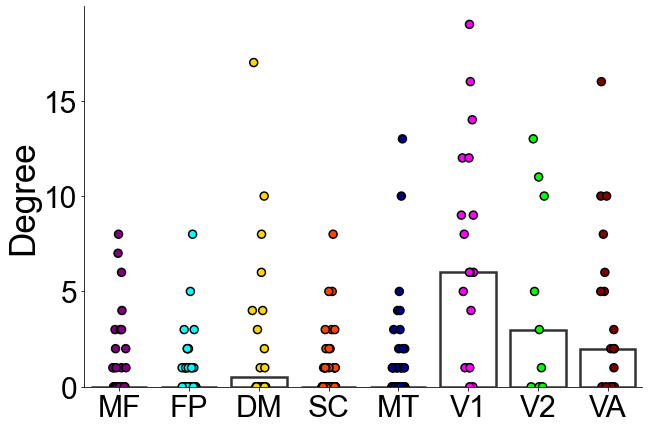

In [17]:
mask_all_edges = (mask_1) & (mask_2) & (mask_3) & (mask_4)
degree_df = pd.DataFrame({'rsn': rsn_networks, 'degree':np.sum(squareform(mask_all_edges), axis=1)})
fig, ax = plt.subplots(figsize=(10,7))
g = sns.stripplot(x='rsn', y='degree', hue='rsn', data=degree_df, ax=ax, 
              size=8, edgecolor="black", linewidth=1.5, c="red", palette=rsn_norm_colors)
sns.barplot(x='rsn', y='degree', data=degree_df, ci=False, linewidth=2.5, facecolor=(1, 1, 1, 0),
                 errcolor=".2", edgecolor=".2", estimator=np.median, ax=ax)
ax.set_xlabel("")
ax.set_ylabel("Degree", size=35)
ax.set_xticklabels(["MF", "FP", "DM", "SC", "MT", "V1", "V2", "VA"])
ax.tick_params(labelsize=30)
plt.legend([],[], frameon=False)
sns.despine()
plt.savefig("../plots/degree_predict_all_edges.png")
plt.savefig("../plots/degree_predict_all_edges.svg")
plt.savefig("../plots/degree_predict_all_edges.pdf")
#sns.boxplot(x='rsn', y='degree', data=degree_df)

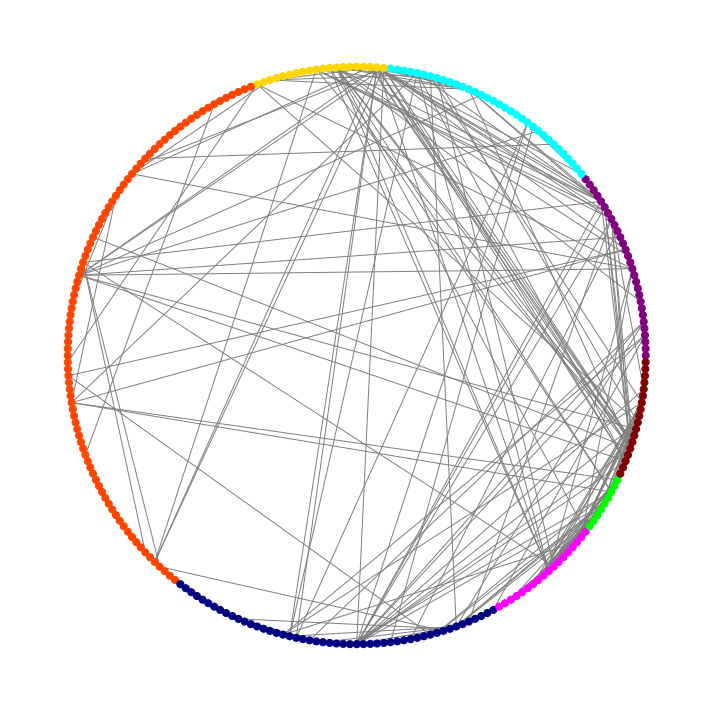

In [19]:
import networkx as nx
indsort = rsn_networks.sort_values().index.to_numpy()
fig, ax = plt.subplots(figsize=(10, 10))
g = nx.from_numpy_array(squareform(mask_all_edges)[indsort,:][:,indsort])
nx.draw_circular(g, node_size=50, 
                 edge_color="grey",
                 alpha=1.0,
                 width=1,
                 node_color=np.array([rsn_norm_colors[ii-1] \
                                      for ii in rsn_networks.to_list()])[indsort], ax=ax)
plt.tight_layout()
plt.savefig("../plots/subnetwork_predict_all_edges.png")
plt.savefig("../plots/subnetwork_predict_all_edges.svg")
plt.savefig("../plots/subnetwork_predict_all_edges.pdf")